importent import

In [503]:
import numpy as np , os
import tensorflow as tf
import collections

gpus = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Preparation
## Quelle  https://medium.com/hackernoon/implementing-a-sequence-to-sequence-model-45a6133958ca

In [504]:
questions = []
answers = []

In [505]:
import os

folder_path = 'data_generation/newQuestions'  # Geben Sie den Pfad zum gewünschten Ordner an

# Durchlaufen aller Dateien im Ordner
que = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
folder_path = 'data_generation/newAnswers' 
ans = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
print(len(que))
print(len(ans))

33
33


In [506]:
for (q,a) in zip(que,ans):
    with open(q, 'r') as inputfile:
        questions += [line.rstrip() for line in inputfile.readlines()[1:]]
    with open(a, 'r') as inputfile:
        answers += [line.rstrip() for line in inputfile.readlines()[1:]]     


In [507]:
print(len(questions))

791


In [508]:
print(len(answers))

791


Einlesen der Fragen

In [509]:
#my better version
file_path = './processed_data/'

with open(file_path+'all_fragen.txt', 'r') as inputfile:
    questions += [line.rstrip() for line in inputfile.readlines()]
    

with open(file_path+'all_antworten.txt', 'r') as inputfile:
    answers += [line.rstrip() for line in inputfile.readlines()]

print(' count questions: %d, count answers: %d'%(len(questions), len(answers)))
#print(antworten)

 count questions: 1099, count answers: 1099


In [510]:
import random
sample_questions = []
sample_answers = []
for x in range(10):
    number = random.randint(0, len(questions))
    #print(str(number))
    sample_questions += [questions[number]]
    sample_answers += [answers[number]]


#for (x,y) in zip(sample_questions,sample_answers):
    #print(x + "\n" + y + "\n \n")

make them all lowercase because that should be better simpler for the net

In [511]:
import re
def make_clean(sentences):
    result = []
    for sentence in sentences:
        txt = sentence.lower()
        txt = re.sub(r"i'm", "i am", txt)
        txt = re.sub(r"he's", "he is", txt)
        txt = re.sub(r"she's", "she is", txt)
        txt = re.sub(r"that's", "that is", txt)
        txt = re.sub(r"what's", "what is", txt)
        txt = re.sub(r"where's", "where is", txt)
        txt = re.sub(r"\'ll", " will", txt)
        txt = re.sub(r"\'ve", " have", txt)
        txt = re.sub(r"\'re", " are", txt)
        txt = re.sub(r"\'d", " would", txt)
        txt = re.sub(r"won't", "will not", txt)
        txt = re.sub(r"can't", "can not", txt)
        txt = re.sub(r"[^\w\s]", "", txt)
        result += [txt]
    return result
bla = ['WHOI o ! ','PAxx s s\' ']
bla = make_clean(bla)
print(bla)

['whoi o  ', 'paxx s s ']


In [512]:
clean_ques = make_clean(questions)
clean_ans = make_clean(answers)

In [513]:
###  count occurences ###
counter_words = {}

for line in clean_ques:
    for word in line.split():
        if word not in counter_words:
            counter_words[word] = 1
        else:
            counter_words[word] += 1
for line in clean_ans:
    for word in line.split():
        if word not in counter_words:
            counter_words[word] = 1
        else:
            counter_words[word] += 1


In [514]:
vocab = {}
word_num = 0
for word, count in counter_words.items():
    vocab[word] = word_num
    word_num += 1

In [515]:
print(vocab)
print(len(vocab))

{'how': 0, 'does': 1, 'tacotron': 2, '2': 3, 'utilize': 4, 'a': 5, 'sequencetosequence': 6, 'architecture': 7, 'what': 8, 'is': 9, 'the': 10, 'purpose': 11, 'of': 12, 'spectral': 13, 'encoder': 14, 'in': 15, 'generate': 16, 'speech': 17, 'from': 18, 'spectrograms': 19, 'role': 20, 'wavenet': 21, 'vocoder': 22, 'are': 23, 'character': 24, 'embeddings': 25, 'used': 26, 'advantages': 27, 'using': 28, 'convolutional': 29, 'networks': 30, 'lstm': 31, 'long': 32, 'shortterm': 33, 'memory': 34, 'relationship': 35, 'between': 36, 'and': 37, 'synthesis': 38, 'handle': 39, 'sentences': 40, 'improvements': 41, 'bring': 42, 'compared': 43, 'to': 44, 'its': 45, 'previous': 46, 'version': 47, 'variations': 48, 'pitch': 49, 'intonation': 50, 'challenges': 51, 'face': 52, 'handling': 53, 'different': 54, 'languages': 55, 'multiple': 56, 'speakers': 57, 'techniques': 58, 'employ': 59, 'ensure': 60, 'naturalsounding': 61, 'with': 62, 'background': 63, 'noise': 64, 'limitations': 65, 'terms': 66, 'genera

start and stop simbole hinzufügen

In [516]:
for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'

anpassen des dics

In [517]:
tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
print(x)
for token in tokens:
    vocab[token] = x
    x += 1
    
    
vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0
print(len(vocab))


1129
1134


In [518]:
### inv answers dict ###
inv_vocab = {w:v for v, w in vocab.items()}

In [519]:
print(len(inv_vocab))

1133


Incoder input durch questions 
wenn Wort nicht bekannt dann vocab out

In [520]:
encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

### delete
del(clean_ans, clean_ques, line, lst, word)    

# found longest length

In [521]:
longest_sequence = 0
for x in encoder_inp+decoder_inp:
    
    if len(x) > longest_sequence:
        longest_sequence = len(x)     
print(longest_sequence)         

26


padding

In [522]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, longest_sequence, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, longest_sequence, padding='post', truncating='post')

In [523]:
#print(encoder_inp)
#print(decoder_inp)
def make_vector_to_sequence(input, dic):
    ints = []
    for k in input:
        try:
            ints.append(inv_vocab[k])
        except Exception as e:
            ints.append(inv_vocab[2])
        
    return ints    

x = make_vector_to_sequence(decoder_inp[5],vocab)
print(x)
x = make_vector_to_sequence(encoder_inp[5],vocab)
print(x)

['<SOS>', 'convolutional', 'networks', 'help', 'capture', 'local', 'dependencies', 'in', 'tacotron', '2', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['what', 'are', 'the', 'advantages', 'of', 'using', 'convolutional', 'networks', 'in', 'tacotron', '2', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


remove the "start of the sequence" simbol in the beginning

In [524]:
decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 

decoder_final_output = pad_sequences(decoder_final_output, longest_sequence, padding='post', truncating='post')

In [525]:
num_categories = len(vocab)  # Check the actual size of your vocabular

In [526]:
#decoder_final_output

convert 2d data to 3d for the LSTM units
creates a separate column for every word in the vocabulary

In [527]:
from tensorflow.keras.utils import to_categorical

num_categories = len(vocab)  # Check the actual size of your vocabulary

# Debugging statements
print("Number of categories:", num_categories)
print("Decoder final output shape:", decoder_final_output.shape)
print("Maximum value in decoder final output:", decoder_final_output.max())

# Convert to one-hot encoded representation
decoder_final_output = to_categorical(decoder_final_output, num_categories)

print(decoder_final_output.shape)

Number of categories: 1134
Decoder final output shape: (1099, 26)
Maximum value in decoder final output: 1130
(1099, 26, 1134)


In [528]:
#print(decoder_final_output)

Verwenden von keras instatt of sequencial weil mehr kontrolle

In [529]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# for both

enc_inp = Input(shape=(longest_sequence, ))
dec_inp = Input(shape=(longest_sequence, ))
# embedding layer reduces dimensionality
# Compress output dim -> voc 722  bzw 300 
VOCAB_SIZE = len(vocab)

In [530]:
VOCAB_SIZE = len(vocab)
embed = Embedding(VOCAB_SIZE+1, output_dim=400, 
                  input_length=longest_sequence,
                  trainable=True                  
                  )


enc_embed = embed(enc_inp)
enc_lstm = LSTM(800, return_sequences=True, return_state=True, dropout=0.1)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c]


dec_embed = embed(dec_inp)
dec_lstm = LSTM(800, return_sequences=True, return_state=True, dropout=0.1)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

dense = Dense(VOCAB_SIZE, activation='softmax')

dense_op = dense(dec_op)

model = Model([enc_inp, dec_inp], dense_op)

In [531]:
train_data_X = encoder_inp[:1000]
train_data_Y = decoder_inp[:1000]
val_data_X = encoder_inp[1000:]
val_data_Y = encoder_inp[1000:]
print(train_data_X[0])
print(val_data_X[0])

[0 1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  0   1   2   3 138  32  33  34  30   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [532]:
from tensorflow.keras.optimizers import Adam
#import pandas as pd

In [533]:
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

In [534]:
#model = tf.keras.models.load_model("trained_models/my_modelNr5.h5")

In [553]:
#model2 = Model([enc_inp, dec_inp], dense_op)
history = None
with tf.device('/GPU:0'):
    history = model.fit([train_data_X, train_data_Y], decoder_final_output[:1000],
    validation_data=([val_data_X, val_data_Y], decoder_final_output[1000:]),
    epochs=100, batch_size=150)
#history_frame = pd.DataFrame(history.history())
#history_frame.loc[:, ['loss', 'val_loss']].plot()
#history_frame.loc[:, ['acc', 'categorical_crossentropy']].plot()

Epoch 1/100
7/7 [==============================] - 10s 1s/step - loss: 0.2131 - acc: 0.9371 - val_loss: 6.0476 - val_acc: 0.4961
Epoch 2/100
7/7 [==============================] - 9s 1s/step - loss: 0.2113 - acc: 0.9367 - val_loss: 6.0740 - val_acc: 0.4969
Epoch 3/100
7/7 [==============================] - 9s 1s/step - loss: 0.2081 - acc: 0.9366 - val_loss: 6.0679 - val_acc: 0.4969
Epoch 4/100
7/7 [==============================] - 9s 1s/step - loss: 0.2063 - acc: 0.9374 - val_loss: 6.0990 - val_acc: 0.4957
Epoch 5/100
7/7 [==============================] - 10s 1s/step - loss: 0.2021 - acc: 0.9380 - val_loss: 6.0907 - val_acc: 0.4977
Epoch 6/100
7/7 [==============================] - 10s 1s/step - loss: 0.1996 - acc: 0.9408 - val_loss: 6.1262 - val_acc: 0.4949
Epoch 7/100
7/7 [==============================] - 10s 1s/step - loss: 0.1975 - acc: 0.9407 - val_loss: 6.0958 - val_acc: 0.4984
Epoch 8/100
7/7 [==============================] - 9s 1s/step - loss: 0.1947 - acc: 0.9405 - val_los

In [536]:
import pickle
def save_model_and_state(enc_name,modelname):
    with open("new_saves/"+ enc_name + ".pkl", 'wb') as f:
        pickle.dump(enc_states, f)
    # Save the model
    model.save("new_saves/"+ modelname + ".h5")

In [537]:
#save_model_and_state("encoder_states", "model")

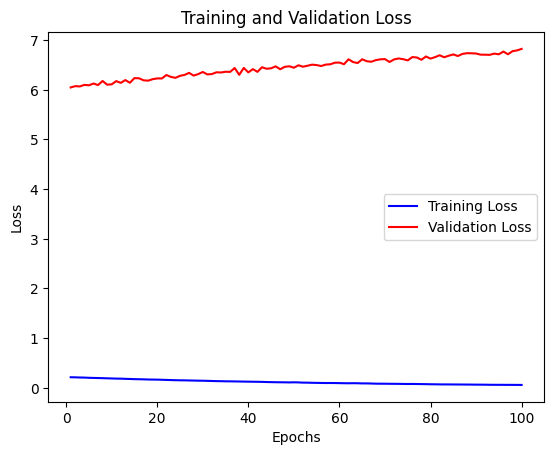

In [554]:
import matplotlib.pyplot as plt

# Get the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

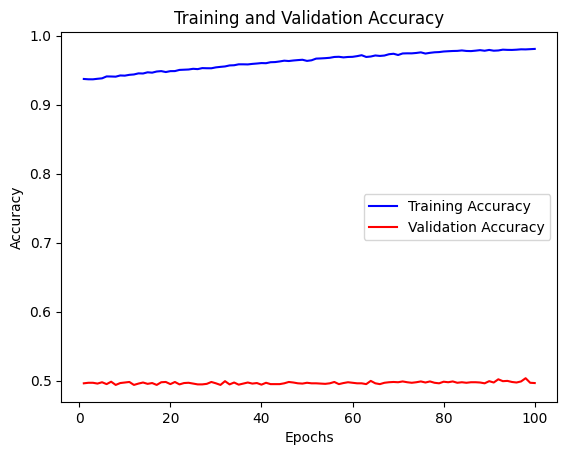

In [555]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot the training and validation loss
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [540]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU detected.")

No GPU detected.


In [541]:
#model = tf.keras.models.load_model("trained_models/my_modelNr5.h5")#

In [542]:
#model = otherModel()
#model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')
#history = model.fit([train_data_X, train_data_Y], decoder_final_output[:1000],
#          validation_data=([val_data_X, val_data_Y], decoder_final_output[1000:]),
#          epochs=100, batch_size=150)
#history_frame = pd.DataFrame(history.history())
#history_frame.loc[:, ['loss', 'val_loss']].plot()
#history_frame.loc[:, ['acc', 'categorical_crossentropy']].plot()

In [543]:
#model2 = Model([enc_inp, dec_inp], dense_op)
#from tensorflow.keras.optimizers import Adam
#model2.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')
#history = model2.fit([encoder_inp,decoder_inp], decoder_final_output,epochs=50, batch_size=150)

In [544]:
#!pip install tensorflow-gpu
#print(tf.test.gpu_device_name())
#!pip install pandas
#!pip install matplotlib

In [545]:
#model.save('trained_models/normalModel_100Epochs.h5')

In [546]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 input_41 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 26, 400)      454000      ['input_41[0][0]',               
                                                                  'input_42[0][0]']               
                                                                                                  
 lstm_24 (LSTM)                 [(None, 26, 800),    3843200     ['embedding_11[0][0]']    

To use modell have to use Interence
To use the modell we need the enc_states

In [556]:
enc_model = Model([enc_inp], enc_states)

# decoder Model
decoder_state_input_h = Input(shape=(800,))
decoder_state_input_c = Input(shape=(800,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# wir verwenden LSTM units mit den trainierten states
# h war hidden state mit Information Kontext 
# c cell state mit Inforamtion über Abhängigkeiten
decoder_outputs, state_h, state_c = dec_lstm(dec_embed , 
                                    initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

dec_model = Model([dec_inp]+ decoder_states_inputs,
                                      [decoder_outputs]+ decoder_states)

In [548]:
def x():
    # Save Encoder Model
    enc_model.save("encoder_model_t4.h5")

    # Save Decoder Model
    dec_model.save("decoder_model_t4.h5")


    from keras.models import load_model

    # Load Encoder Model
    #enc_model = load_model("encoder_model_t3.h5")

    # Load Decoder Model
   # dec_model = load_model("decoder_model_t3.h5")
x()

In [549]:
def create_pred_input(sentence):
    X_in = []
    for word in sentence.lower().split():
        try:
            X_in.append(vocab[word])
        except:
            X_in.append(vocab['<OUT>'])
            pass
    print(X_in)    
    return pad_sequences([X_in], longest_sequence, padding='post')

input_for_prediction = create_pred_input('What is Tacotron 2 ?')

[8, 9, 2, 3, 1131]


In [550]:
def predict_sentence(sentences):
    sentences = make_clean(sentences)
    for sentence in sentences:
        print("Question  : " + sentence + "/n")
        pred_input = create_pred_input(sentence)
        stat = enc_model.predict(pred_input)
        print("make predicted Input for " + str(pred_input))
        empty_target_seq = np.zeros( ( 1 , 1) )
        ##   empty_target_seq = [0]
        empty_target_seq[0, 0] = vocab['<SOS>']       

        stop_condition = False
        decoded_translation = ''
        while not stop_condition :

            dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
            decoder_concat_input = dense(dec_outputs)
            ## decoder_concat_input = [0.1, 0.2, .4, .0, ...............]

            sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
            ## sampled_word_index = [2]

            sampled_word = inv_vocab[sampled_word_index] + ' '

            ## inv_vocab[2] = 'hi'
            ## sampled_word = 'hi '

            if sampled_word != '<EOS> ':
                decoded_translation += sampled_word  

            if sampled_word == '<EOS> ' or len(decoded_translation.split()) > longest_sequence:
                stop_condition = True 

            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            ## <SOS> - > hi
            ## hi --> <EOS>
            stat = [h, c]  

        print("chatbot : ", decoded_translation )
        print("============================================== \n")  

In [551]:
Testset = ["How does Tacotron 2 utilize a Sequence-to-Sequence architecture?",
"What is the purpose of the Spectral Encoder in Tacotron 2?",
"How does Tacotron 2 generate speech from spectrograms?"
"What is the role of the WaveNet Vocoder in Tacotron 2",
"How are character embeddings used in Tacotron 2?",
"What are the advantages of using convolutional networks in Tacotron 2?"]
#print(])
predict_sentence([questions[0],questions[1],questions[2]])


#predict_sentence(answers[0])
Testset = ["Can the Tacotron 2 deal with speech",
           "Can it generate speech",
           "what are current challenges",
           "Is it a sequence2sequence model",
           "How many language"
           ]
predict_sentence(Testset)




Question  : how does tacotron 2 utilize a sequencetosequence architecture/n
[0, 1, 2, 3, 4, 5, 6, 7]
1/1 [==============================] - 0s 281ms/step
make predicted Input for [[0 1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 17ms/step
chatbot :  tacotron 2 utilizes lstm units for modeling longterm dependencies in the speech synthesis 

Question  : what is the purpose of the spectral encoder in tacotron 2/n
[8, 9, 10, 11, 12, 10, 13, 14, 15, 2, 3]
1/1 [==============================] - 0s 22ms/step
make predicted Input for [[ 8  9 10 11 12 10 13 14 15  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
1/1 [==============================] - 0s 16ms/step
chatbot :  the spectral encoder in tacotron 2 converts melscale spectrograms into highresolution spectrograms 

Question  : how does tacotron 2 generate speech from spectrograms/n
[0, 1, 2, 3, 16, 17, 18, 19]
1/1 [==============================] - 0s 21ms/step
make predicted Input fo

In [552]:
print(vocab)

{'how': 0, 'does': 1, 'tacotron': 2, '2': 3, 'utilize': 4, 'a': 5, 'sequencetosequence': 6, 'architecture': 7, 'what': 8, 'is': 9, 'the': 10, 'purpose': 11, 'of': 12, 'spectral': 13, 'encoder': 14, 'in': 15, 'generate': 16, 'speech': 17, 'from': 18, 'spectrograms': 19, 'role': 20, 'wavenet': 21, 'vocoder': 22, 'are': 23, 'character': 24, 'embeddings': 25, 'used': 26, 'advantages': 27, 'using': 28, 'convolutional': 29, 'networks': 30, 'lstm': 31, 'long': 32, 'shortterm': 33, 'memory': 34, 'relationship': 35, 'between': 36, 'and': 37, 'synthesis': 38, 'handle': 39, 'sentences': 40, 'improvements': 41, 'bring': 42, 'compared': 43, 'to': 44, 'its': 45, 'previous': 46, 'version': 47, 'variations': 48, 'pitch': 49, 'intonation': 50, 'challenges': 51, 'face': 52, 'handling': 53, 'different': 54, 'languages': 55, 'multiple': 56, 'speakers': 57, 'techniques': 58, 'employ': 59, 'ensure': 60, 'naturalsounding': 61, 'with': 62, 'background': 63, 'noise': 64, 'limitations': 65, 'terms': 66, 'genera